# Compare ImplicitRNN to LSTM on Argmax Extrapolation Task 

## Imports

In [16]:
from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)

from implicitdl import ImplicitRNNCell

import torch
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda')
print('using ' + str(device))

import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(123)
%matplotlib inline

using cuda


## Data Generation

In [2]:
SAMPLES = 10000
SEQ_LEN = 10
DIM = 1

def make_data(factor=1):
    src = torch.rand(SAMPLES, SEQ_LEN, DIM, device=device)*2*factor - factor
    y = src.argmax(dim=1).squeeze()
    
    return src, y

## Training Code

In [3]:
def train(model, src, y, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []
    accs = []
    
    model.train()
    with trange(epochs) as it:
        for i in it:
            pred = model(src)
            loss = F.cross_entropy(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            losses.append(loss.item())
            accs.append((pred.argmax(dim=-1)==y).to(float).mean().item())
            it.set_postfix(lr=scheduler.get_last_lr()[0])

    return losses, accs

## Model Construction

In [4]:
class ImplicitRNN(nn.Module):
    def __init__(self, n, hidden_size):
        super().__init__()
        self.implicit = ImplicitRNNCell(DIM, n, hidden_size)
        self.linear = nn.Linear(hidden_size, SEQ_LEN)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)
    
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=DIM, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, SEQ_LEN)
        
    def forward(self, x, init_state=None):
        outputs, (h_n, c_n) = self.lstm(x, init_state)
        return self.linear(h_n.squeeze(0))

In [5]:
imprnn = ImplicitRNN(20, 20).to(device)
print(imprnn)

ImplicitRNN(
  (implicit): ImplicitRNNCell(
    (layer): ImplicitModel()
  )
  (linear): Linear(in_features=20, out_features=10, bias=True)
)


In [6]:
lstm = LSTM(20).to(device)
print(lstm)

LSTM(
  (lstm): LSTM(1, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=10, bias=True)
)


In [7]:
models = {
    'ImplicitRNN': imprnn,
    'LSTM': lstm
}

print('Model Sizes:')
for name, model in models.items():
    print(f'{name}: {sum(p.numel() for p in model.parameters())} parameters')

Model Sizes:
ImplicitRNN: 1850 parameters
LSTM: 2050 parameters


## Train and Evaluate
- Takes about 8 minutes to run on one NVIDIA Tesla P100-PCIE-16GB
- The "Picard iterations did not converge" warnings can be ignored for this experiment.

In [8]:
EPOCHS = 1000
LR = 0.02

src, y = make_data()

In [9]:
losses = {}
accs = {}

for name, model in models.items():
    print(name)
    losses[name], accs[name] = train(model, src, y, EPOCHS, LR)

ImplicitRNN


  0%|          | 0/1000 [00:00<?, ?it/s]

LSTM


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
extrap_losses = {name: [] for name in models}
extrap_accs = {name: [] for name in models}
factors = np.logspace(1, 5, num=100)
for factor in tqdm(factors):
    src_test, y_test = make_data(factor/2)
    for name, model in models.items():
        with torch.no_grad():
            pred = model(src_test)
            extrap_losses[name].append(F.cross_entropy(pred, y_test).item())
            extrap_accs[name].append((pred.argmax(dim=-1)==y_test).to(float).mean().item())

  0%|          | 0/100 [00:00<?, ?it/s]

Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard itera

Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=1.5259e-05, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=1.5259e-05, status=max itrs reached
Picard iterations did not converge: err=1.5259e-05, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard itera

Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=1.5259e-05, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=3.8147e-06, status=max itrs reached
Picard itera

Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=7.6294e-06, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard itera

Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=3.0518e-05, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard itera

Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=6.1035e-05, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard itera

Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=1.2207e-04, status=max itrs reached
Picard iterations did not converge: err=2.4414e-04, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard itera

Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=7.8125e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=7.8125e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=4.8828e-04, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=3.9062e-03, status=max itrs reached
Picard iterations did not converge: err=7.8125e-03, status=max itrs reached
Picard itera

Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=7.8125e-03, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=3.1250e-02, status=max itrs reached
Picard iterations did not converge: err=1.9531e-03, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=9.7656e-04, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard iterations did not converge: err=1.5625e-02, status=max itrs reached
Picard itera

## Display Results
Notice that the ImplicitRNN greatly improves upon the LSTM in terms of extrapolation accuracy (first plot).

In [11]:
styles = ['-', '--']

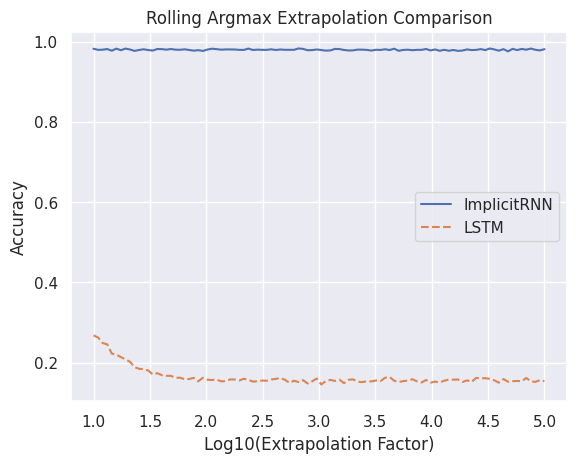

In [20]:
fig, ax = plt.subplots()
for style, (name, extrap_acc) in zip(styles, extrap_accs.items()):
    ax.plot(np.log10(factors), extrap_acc, label=name, ls=style)

ax.set_title(f'Rolling Argmax Extrapolation Comparison')
ax.set_xlabel('Log10(Extrapolation Factor)')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

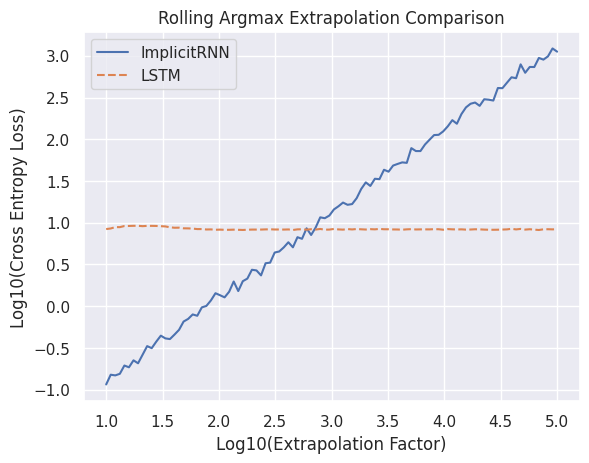

In [19]:
fig, ax = plt.subplots()
for style, (name, extrap_loss) in zip(styles, extrap_losses.items()):
    ax.plot(np.log10(factors), np.log10(extrap_loss), label=name, ls=style)

ax.set_title(f'Rolling Argmax Extrapolation Comparison')
ax.set_xlabel('Log10(Extrapolation Factor)')
ax.set_ylabel('Log10(Cross Entropy Loss)')
ax.legend()
plt.show()

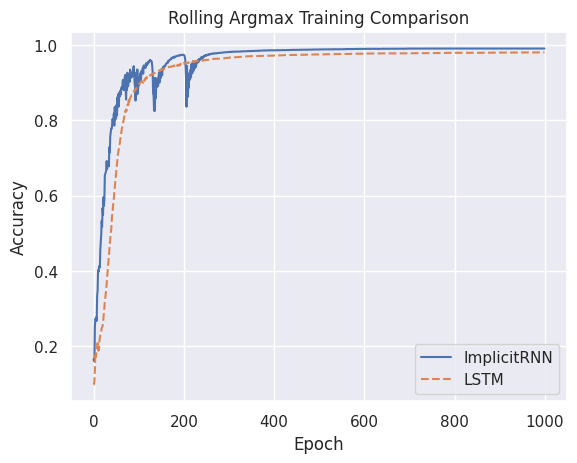

In [18]:
fig, ax = plt.subplots()
for style, (name, acc) in zip(styles, accs.items()):
    ax.plot(acc, label=name, ls=style)

ax.set_title(f'Rolling Argmax Training Comparison')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

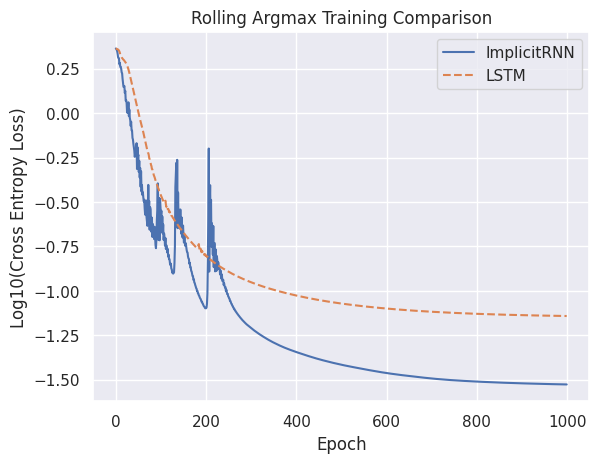

In [17]:
fig, ax = plt.subplots()
for style, (name, train_loss) in zip(styles, losses.items()):
    ax.plot(np.log10(train_loss), label=name, ls=style)

ax.set_title(f'Rolling Argmax Training Comparison')
ax.set_xlabel('Epoch')
ax.set_ylabel('Log10(Cross Entropy Loss)')
ax.legend()
plt.show()